In [52]:
from scipy.stats import crystalball, norm, expon
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad



def g_s(X,beta,m,mu,sigma):
    pdf=crystalball(beta,m,loc=mu,scale=sigma)
    norm_factor = pdf.cdf(5)-pdf.cdf(0)
    trunc_pdf= pdf.pdf(X)/norm_factor
    return trunc_pdf


def h_s(Y,lam):
    pdf = expon(scale=1/lam)
    norm_factor = pdf.cdf(10)-pdf.cdf(0)
    trunc_pdf = pdf.pdf(Y)/norm_factor
    return trunc_pdf

def g_b(X):
    pdf=1/5*np.ones_like(X)
    return pdf

def h_b(Y,mu_b,sigma_b):
    pdf = norm(loc=mu_b,scale=sigma_b)
    norm_factor=pdf.cdf(10)-pdf.cdf(0)
    trunc_pdf = pdf.pdf(Y)/norm_factor  
    return trunc_pdf

def f_tot(X,Y,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    pdf = f*g_s(X,beta,m,mu,sigma)*h_s(Y,lam)+(1-f)*g_b(X)*h_b(Y,mu_b,sigma_b)
    return pdf






In [53]:
mu_true = 3
sigma_true = 0.3
beta_true= 1
m_true = 1.4
f_true =0.6
lam_true=0.3
mu_b_true =0
sigma_b_true = 2.5


g_s_integral, g_s_error = quad(lambda x: g_s(x, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true), 0, 5)
h_s_integral, h_s_error = quad(lambda x: h_s(x, lam=lam_true), 0, 10)
g_b_integral, g_b_error = quad(g_b, 0, 5)  # Assuming g_b doesn't need extra parameters
h_b_integral, h_b_error = quad(lambda x: h_b(x, mu_b=mu_b_true, sigma_b=sigma_b_true), 0, 10)

x_min=0
x_max=5
y_min=0 
y_max=10
# Print the results
print(f"Integral of g_s(x) from {x_min} to {x_max}: {g_s_integral:.6f} (Error estimate: {g_s_error:.6e})")
print(f"Integral of h_s(y) from {y_min} to {y_max}: {h_s_integral:.6f} (Error estimate: {h_s_error:.6e})")
print(f"Integral of g_b(x) from {x_min} to {x_max}: {g_b_integral:.6f} (Error estimate: {g_b_error:.6e})")
print(f"Integral of h_b(y) from {y_min} to {y_max}: {h_b_integral:.6f} (Error estimate: {h_b_error:.6e})")

Integral of g_s(x) from 0 to 5: 1.000000 (Error estimate: 7.289797e-09)
Integral of h_s(y) from 0 to 10: 1.000000 (Error estimate: 1.110223e-14)
Integral of g_b(x) from 0 to 5: 1.000000 (Error estimate: 1.110223e-14)
Integral of h_b(y) from 0 to 10: 1.000000 (Error estimate: 4.839198e-12)


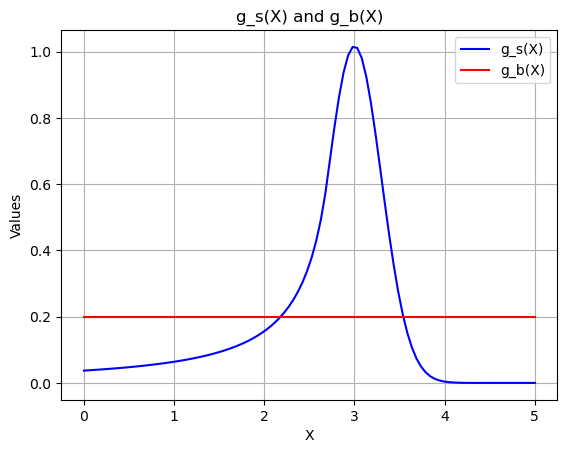

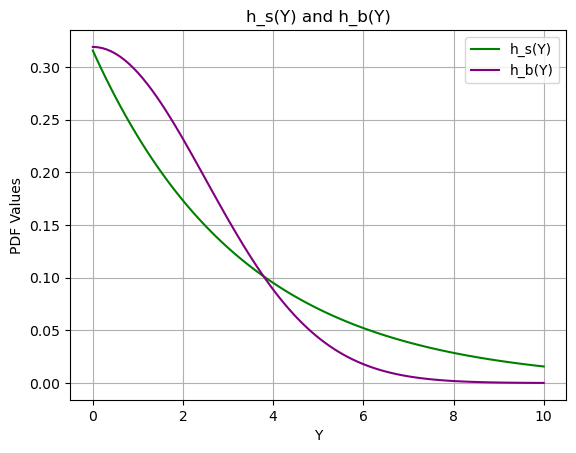

In [54]:



X=np.linspace(0,5,100)
Y=np.linspace(0,10,100)
plt.figure(1)  # First figure
plt.plot(X, g_s(X, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true), label="g_s(X)", color='blue')
plt.plot(X, g_b(X), label="g_b(X)", color='red')
plt.title("g_s(X) and g_b(X)")
plt.xlabel("X")
plt.ylabel("Values")
plt.legend()
plt.grid(True)

# Create the second figure for h_s(Y) and h_b(Y)
plt.figure(2)  # Second figure
plt.plot(Y, h_s(Y, lam=lam_true), label="h_s(Y)", color='green')
plt.plot(Y, h_b(Y, mu_b=mu_b_true, sigma_b=sigma_b_true), label="h_b(Y)", color='purple')
plt.title("h_s(Y) and h_b(Y)")
plt.xlabel("Y")
plt.ylabel("PDF Values")
plt.legend()
plt.grid(True)

# Show both figures
plt.show()

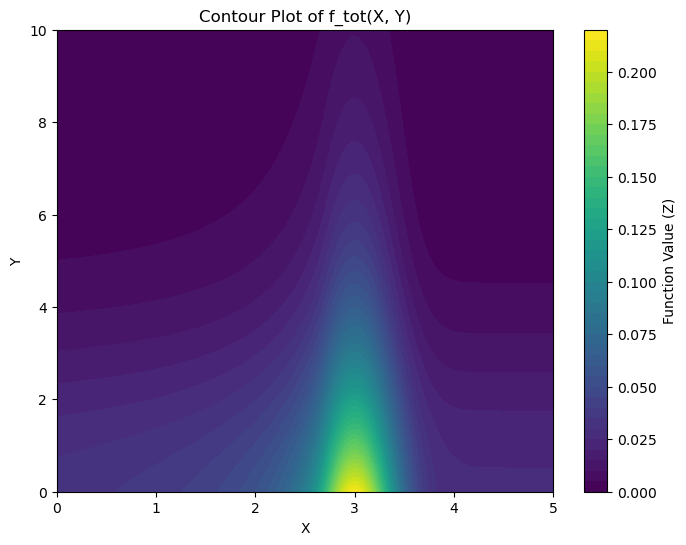

In [55]:


X, Y = np.meshgrid(X, Y)
Z = f_tot(X, Y, f=f_true, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true, lam=lam_true, mu_b=mu_b_true, sigma_b=sigma_b_true)

# Alternatively, you can use a filled contour plot:
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value (Z)')
plt.title("Contour Plot of f_tot(X, Y)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [192]:

# max_value = np.max(Z)

# def accept_reject(N):  #change to batch generation
#     accepted_points=[]
#     rejected_points=[]
#     with tqdm(total=N, desc="Sampling", unit="sample") as pbar:
#         while len(accepted_points)<N:
#             x=np.random.uniform(0, 5)
#             y=np.random.uniform(0, 10)
#             y_guess=np.random.uniform(0, max_value)
#             y_val=f_tot(x,y,f=f_true,beta=beta_true,m=m_true,mu=mu_true,sigma=sigma_true,lam=lam_true,mu_b=mu_b_true,sigma_b=sigma_b_true)
#             if y_guess<=y_val:
#                 accepted_points.append((x, y))
#                 pbar.update(1)  
#             #else:    
#                 #rejected_points.append((x, y)) 

        
#     return accepted_points


# sample = accept_reject(100000)


In [193]:
max_value = np.max(Z)
def faster_event_generation(N):
    accepted_points = []
    
    while len(accepted_points)<N:
        x_batch = np.random.uniform(0, 5, int(N/2))
        y_batch = np.random.uniform(0, 10, int(N/2))
        y_guess = np.random.uniform(0, max_value, int(N/2))
        y_val = f_tot(x_batch, y_batch, f=f_true, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true, lam=lam_true, mu_b=mu_b_true, sigma_b=sigma_b_true)
        accepted_indices = y_guess <= y_val
        # Add accepted points to the list
        accepted_points.extend(zip(x_batch[accepted_indices], y_batch[accepted_indices]))
            
            
    accepted_points = np.array(accepted_points[:N])
    
    return accepted_points
    

sample = faster_event_generation(100000)   

        


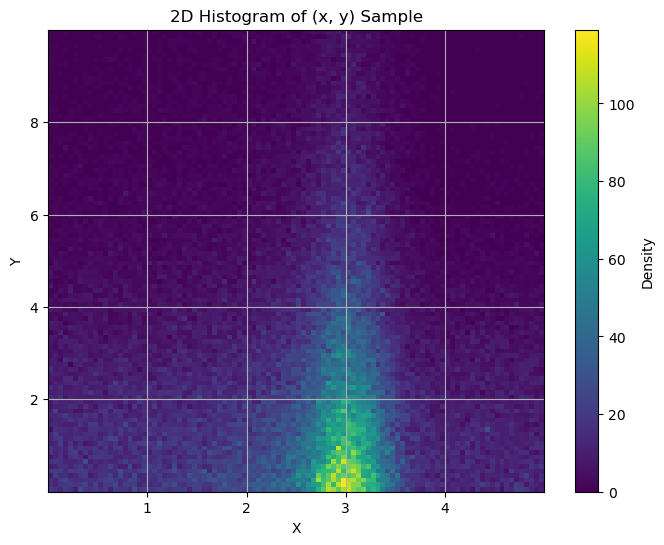

In [194]:
#saved_sample = np.array(sample)
x = sample[:, 0]
y = sample[:, 1]
plt.figure(figsize=(8, 6))
plt.hist2d(x, y, bins=100, cmap='viridis')

# Add a colorbar to show the number of points in each bin
plt.colorbar(label='Density')

plt.title("2D Histogram of (x, y) Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

In [195]:
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

def density(data,N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    #X=data[:,0]
    #Y=data[:,1]
    X,Y =data
    return N, N*f_tot(X,Y,f,beta,m,mu,sigma,lam,mu_b,sigma_b)

nll = ExtendedUnbinnedNLL(sample.T, density)

mi = Minuit(nll , N=100000, f=0.6 ,beta=1 ,m=1.4 ,mu=3 ,sigma=0.3 ,lam=0.3 ,mu_b=0.0 ,sigma_b=2.5)

mi.migrad()

mi.hesse()




In [99]:
import timeit

def run_faster_event_generation():
    faster_event_generation(100000)

def run_normal_dist():
    np.random.normal(size=100000)

def run_fit():
    mi.migrad()

time_norm = timeit.timeit(run_normal_dist, number=100)
average_time_norm = time_norm / 100

time_gen = timeit.timeit(run_faster_event_generation, number=100)
average_time_gen = time_gen / 100
average_time_gen_rel=average_time_gen/average_time_norm

time_fit = timeit.timeit(run_fit, number=100)
average_time_fit = time_fit / 100
average_time_fit_rel=average_time_fit/average_time_norm



print(f"Average time for 100 runs of normal dist: {average_time_norm:.4f} seconds")
print(f"Average relative time for 100 runs of event generation: {average_time_gen_rel:.4f} ")
print(f"Average relative time for 100 runs of fitting: {average_time_fit_rel:.4f}")


Average time for 100 runs of normal dist: 0.0013 seconds
Average relative time for 100 runs of event generation: 107.0542 
Average relative time for 100 runs of fitting: 294.8313


In [203]:
from tqdm import tqdm 

def generate(N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    accepted_points = []
    N=int(N)
    while len(accepted_points)<N:
        x_batch = np.random.uniform(0, 5, int(N/2))
        y_batch = np.random.uniform(0, 10, int(N/2))
        y_guess = np.random.uniform(0, max_value, int(N/2))
        y_val = f_tot(x_batch, y_batch, f, beta, m, mu, sigma, lam, mu_b, sigma_b)
        accepted_indices = y_guess <= y_val
        # Add accepted points to the list
        accepted_points.extend(zip(x_batch[accepted_indices], y_batch[accepted_indices]))
            
    accepted_points = np.array(accepted_points[:N])
    
    return accepted_points


def fit(dset,N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    nll = ExtendedUnbinnedNLL(dset.T, density)
    mi = Minuit(nll , N, f ,beta ,m ,mu ,sigma ,lam ,mu_b ,sigma_b)
    mi.migrad ()
    mi.hesse ()
    return mi

def fit_toys(Ntoy,sample_size,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    values =[]
    errors = []
    Num=np.random.poisson(sample_size)
    toys = [ generate(Num,f,beta,m,mu,sigma,lam,mu_b,sigma_b) for _ in range(Ntoy) ]
    for toy in tqdm(toys):
        mi_t = fit(toy,sample_size,f,beta,m,mu,sigma,lam,mu_b,sigma_b)
        values.append( list(mi_t.values) )
        errors.append( list(mi_t.errors) )
    return values, errors






In [213]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
def generate(N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    accepted_points = []
    N=int(N)
    while len(accepted_points)<N:
        x_batch = np.random.uniform(0, 5, int(N/2))
        y_batch = np.random.uniform(0, 10, int(N/2))
        y_guess = np.random.uniform(0, max_value, int(N/2))
        y_val = f_tot(x_batch, y_batch, f, beta, m, mu, sigma, lam, mu_b, sigma_b)
        accepted_indices = y_guess <= y_val
        # Add accepted points to the list
        accepted_points.extend(zip(x_batch[accepted_indices], y_batch[accepted_indices]))
            
    accepted_points = np.array(accepted_points[:N])
    
    return accepted_points


def fit(dset,N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    nll = ExtendedUnbinnedNLL(dset.T, density)
    mi = Minuit(nll , N, f ,beta ,m ,mu ,sigma ,lam ,mu_b ,sigma_b)
    mi.migrad ()
    mi.hesse ()
    return mi

# Parallelized function for generating toys and fitting them
def fit_toys_parallel(Ntoy, sample_size, f, beta, m, mu, sigma, lam, mu_b, sigma_b):
    values = []
    errors = []
    Num = np.random.poisson(sample_size,Ntoy)
    
    # Using ProcessPoolExecutor to generate toys in parallel
    with ProcessPoolExecutor() as executor:
        # Generate toys in parallel
        args_gen = [(Num[i],f,beta,m,mu,sigma,lam,mu_b,sigma_b) for i in range(Ntoy)]
        toys = list(executor.map(generate, args_gen))


    with ProcessPoolExecutor() as executor:
        # Generate toys in parallel
        # Fit the toys in parallel
        results = list(executor.map(fit, toys, args_gen))
        
        # Collect results from the fits
        for mi_t in results:
            values.append(list(mi_t.values))
            errors.append(list(mi_t.errors))
    
    return values, errors


# Running the fitting procedure
Ntoy = 250
values ,errors = fit_toys_parallel(Ntoy,500,*mi.values[1:])


Process SpawnProcess-86:
Process SpawnProcess-85:
Traceback (most recent call last):
  File "/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'generate' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/multiprocessing/process.

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [196]:

Ntoy = 250
sample_size_means=[500, 1000, 2500, 5000, 10000]
truth = np.array(list(mi.values))


 



In [ ]:
for size in sample_size_means:
    values, errors = fit_toys(Ntoy,size,*mi.values[1:])
    #plt.hist(values, bins=20, histtype='step', label=f"Sample size: {size}")


In [197]:
values ,errors = fit_toys(Ntoy,500,*mi.values[1:])


  3%|▎         | 8/250 [00:03<01:32,  2.61it/s]/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11118: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11086: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11086: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/27/607d42hs7jz87b8yg71lpk5r0000gn/T/ipykernel_93093/4277963234.py:11: RuntimeWarning: invalid value encountered in divide
  trunc_pdf= pdf.pdf(X)/norm_factor
/Users/ellacole/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:11118: RuntimeWarning: invalid value encountered in multiply
  retur

In [156]:
print(np.shape(values))

(250, 9)


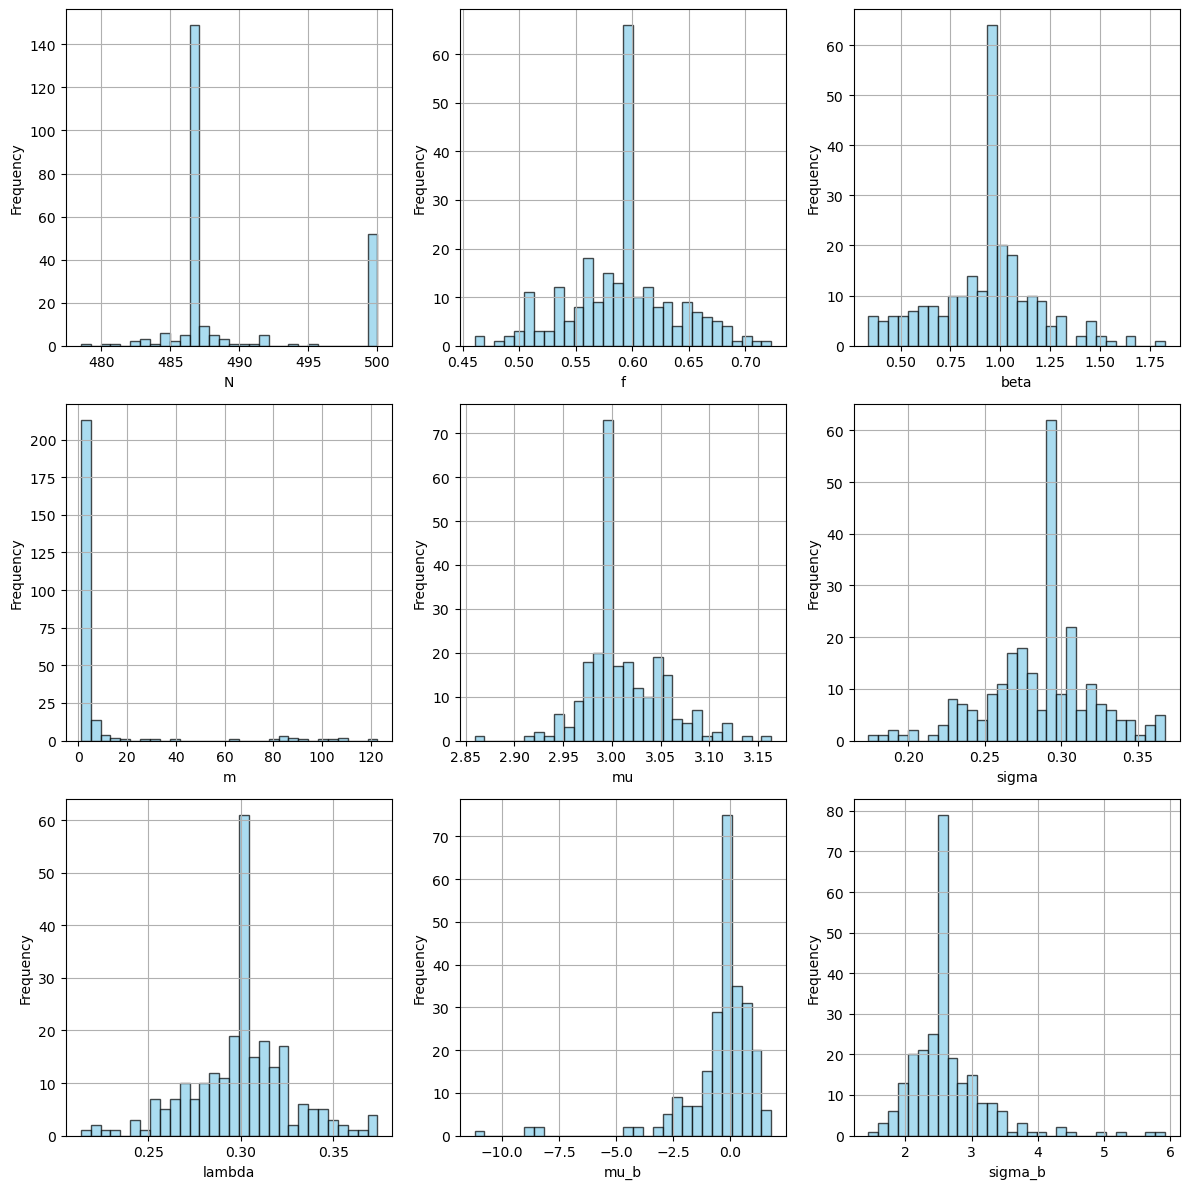

In [180]:

values = np.array(values)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid for 9 subplots
Names = ['N', 'f', 'beta', 'm', 'mu', 'sigma', 'lambda', 'mu_b', 'sigma_b']
# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Loop through each column (parameter) in the values array and plot a histogram
for i in range(9):
    axes[i].hist(values[:, i], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
     # Set the title for each subplot
    axes[i].set_xlabel(Names[i])
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

ValueError: supplied range of [nan, nan] is not finite

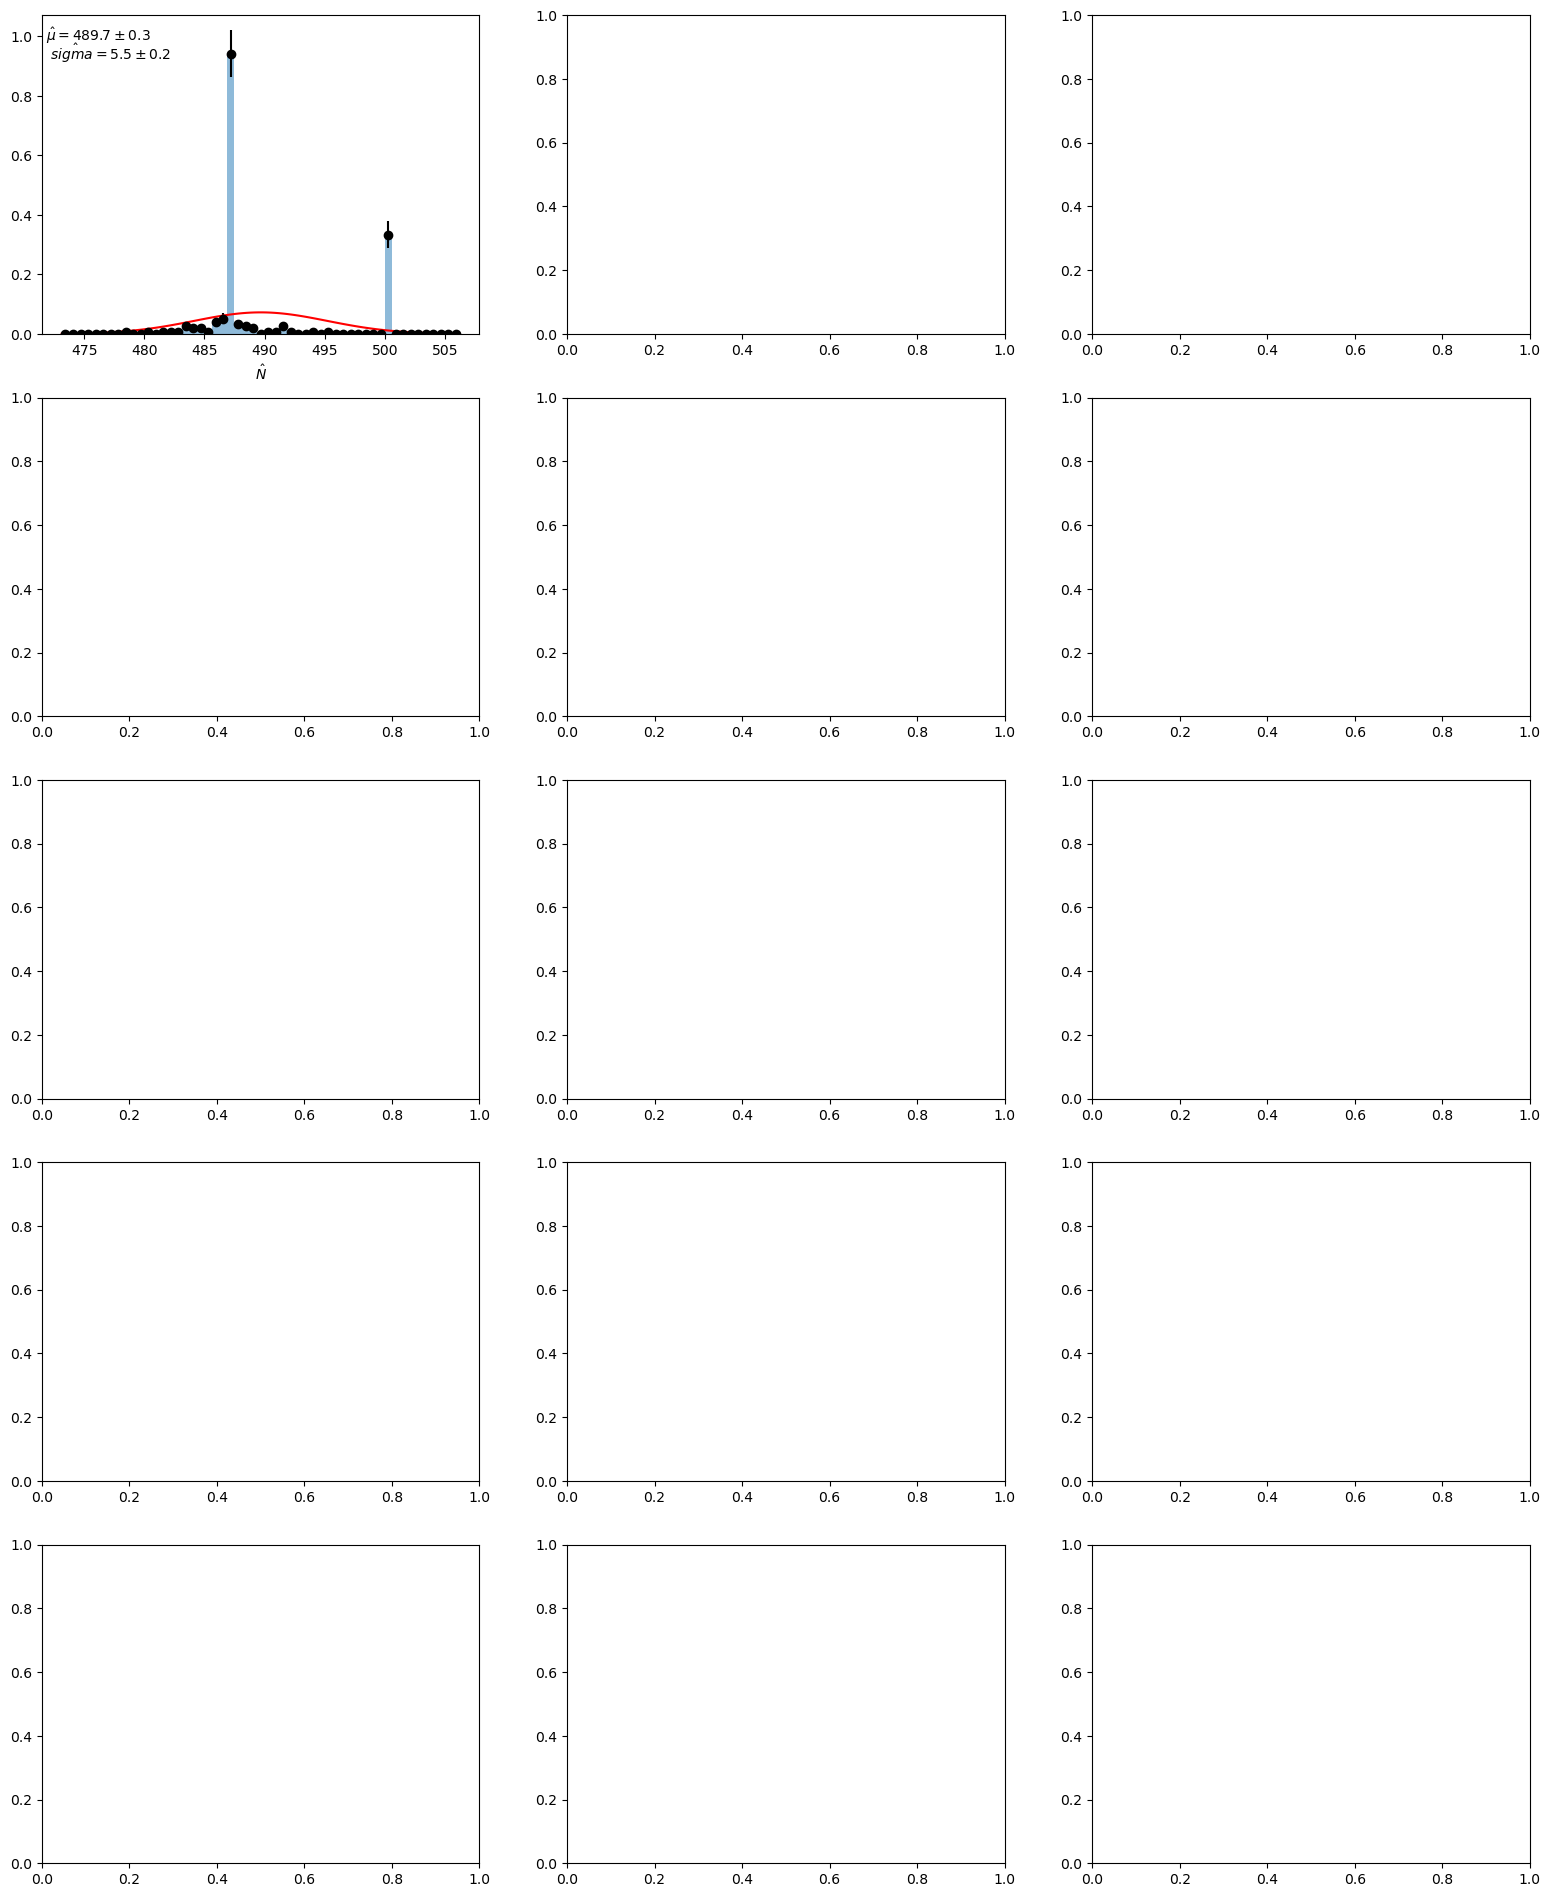

In [188]:
import uncertainties as uncert
def plot(xvals , ax=None):
    ax = ax or plt.gca()
    # compute mean , sdev and their errors of distribution
    m = np.mean(xvals)
    s = np.std(xvals , ddof=1)
    me = s/len(xvals)**0.5
    se = s/(2*len(xvals)-1)**0.5
    # make a density histogram
    nh, xe = np.histogram( xvals , range =(m-3*s,m+3*s), bins='auto', density=True )
    # draw the density histogram
    ax.hist( xvals , bins=xe, density=True , alpha=0.5 )
    # also draw error bars on points
    N = np.sum(nh)/len(xvals)
    cx = 0.5*(xe[1:]+xe[:-1])
    ax.errorbar( cx, nh, N*(nh/N)**0.5, fmt='ko')
    # draw the normal distribution with the mean and sigma
    x = np.linspace(xe[0],xe[-1],100)
    ax.plot(x, norm.pdf(x,m,s), 'r-')
    # plot the results (use uncertainties package for nice formatting)
    um = uncert.ufloat( m, me )
    us = uncert.ufloat( s, se )
    mstr = f"{um:.1u}".replace("+/-","\pm")
    sstr = f"{us:.1u}".replace("+/-","\pm")
    ax.text(0.01,0.92, f"$\hat{{\mu}} = {mstr}$", transform=ax.transAxes)   
    ax.text(0.01,0.86, f"$\hat{{\ sigma}} = {sstr}$", transform=ax.transAxes)


errors = np.array(errors)
pulls = (values - truth)/errors
fig , axes = plt.subplots(5,3, figsize =(19.2,24))
for i, name in enumerate(Names):
    estname = f"\hat {{{ name.split('_ ')[0]}}}"
    if len(name.split('_'))>1: estname += '_'+name.split('_')[1]
    
    ax = axes[i,0]
    plot( values[:,i], ax )
    ax.set_xlabel( f"${estname}$" )

    ax = axes[i,1]
    plot( errors[:,i]**2, ax )
    ax.set_xlabel( f"$\hat{{V}}({ name})$" )
    
    ax = axes[i,2]
    plot( pulls[:,i], ax )
    ax.set_xlabel( f"$p({ estname })$" )


In [191]:
print(errors)


[[22.15488068  0.04270483  0.31749591 ...  0.02599124  0.51661861
   0.34149963]
 [        nan         nan         nan ...         nan         nan
          nan]
 [22.06801875  0.05155488  0.19436146 ...  0.03057411  0.98959081
   0.45951962]
 ...
 [22.13528503  0.06034328  0.67735153 ...  0.02847321  1.63211229
   0.71837758]
 [22.06740301  0.05136156  0.33517363 ...  0.03112572  2.64372837
   0.89714033]
 [18.36180801  0.14383841  1.2370964  ...  0.02842195  0.43036975
   0.26025883]]
